<br><br><br><br><br>

# Coding Fast and Fast Code

<br><br><br><br><br>

<br><br><br><br><br>

# Libraries for faster math

<br><br><br><br><br>

In [1]:
import uproot
import numpy
import math

arrays = (uproot.open("http://scikit-hep.org/uproot/examples/Zmumu.root")["events"]
                .arrays(["E*", "p*"], namedecode="utf-8"))

for n in arrays:
    exec(f"{n} = numpy.repeat(arrays['{n}'], 10000)")
    exec(f"{n}_tiny = arrays['{n}'].tolist()")

def baseline_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    out = []
    for i in range(len(E1)):
        out.append(math.sqrt((E1[i] + E2[i])**2 - (px1[i] + px2[i])**2 -
                             (py1[i] + py2[i])**2 - (pz1[i] + pz2[i])**2))
    return out

masses = baseline_calculate(E1_tiny, E2_tiny, px1_tiny, px2_tiny, py1_tiny, py2_tiny, pz1_tiny, pz2_tiny)
masses[0]

82.46269155513643

In [2]:
%%timeit

# All speed tests, other than this pure Python one, will use a dataset 10000 times larger.

masses = baseline_calculate(E1_tiny, E2_tiny, px1_tiny, px2_tiny, py1_tiny, py2_tiny, pz1_tiny, pz2_tiny)

1.92 ms ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [3]:
import numpy
import numexpr

# The Numpy way: compute a step for all values before moving to the next step
def numpy_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    return numpy.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)

# The NumExpr way: compute a whole expression for each value before moving to the next value
numexpr_calculate = numexpr.NumExpr(
    "sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)")

# and do it in parallel (ufunc-like expressions are embarrassingly parallel)
numexpr.set_num_threads(12)

12

In [4]:
%%timeit

masses = numpy_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2)

449 ms ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit

masses = numexpr_calculate.run(E1, E2, px1, px2, py1, py2, pz1, pz2)

70 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
numexpr.disassemble(numexpr_calculate)

[(b'add_ddd', b't9', b'r1[E1]', b'r2[E2]'),
 (b'mul_ddd', b't9', b't9', b't9'),
 (b'add_ddd', b'r0', b'r3[px1]', b'r4[px2]'),
 (b'mul_ddd', b'r0', b'r0', b'r0'),
 (b'sub_ddd', b't9', b't9', b'r0'),
 (b'add_ddd', b'r0', b'r5[py1]', b'r6[py2]'),
 (b'mul_ddd', b't10', b'r0', b'r0'),
 (b'sub_ddd', b'r0', b't9', b't10'),
 (b'add_ddd', b't9', b'r7[pz1]', b'r8[pz2]'),
 (b'mul_ddd', b't9', b't9', b't9'),
 (b'sub_ddd', b't10', b'r0', b't9'),
 (b'sqrt_dd', b'r0', b't10', None)]

In [7]:
import formulate

# Convert ROOT's TTree::Draw expressions to and from NumExpr

(formulate.from_root(
    "TMath::Sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)")
          .to_numexpr())

'sqrt((((E1 + E2) ** 2) - ((px1 + px2) ** 2) - ((py1 + py2) ** 2) - ((pz1 + pz2) ** 2)))'

<br><br><br>

<center><img src="img/numba-logo.png" width="30%"></center>

<br><br><br>

In [8]:
import numba
import math

# The Numba way: compile Python functions as though they were C code
@numba.jit
def numba_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    out = numpy.empty(len(E1))
    for i in range(len(E1)):
        out[i] = math.sqrt(
            (E1[i] + E2[i])**2 - (px1[i] + px2[i])**2 - (py1[i] + py2[i])**2 - (pz1[i] + pz2[i])**2)
    return out

masses = numba_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2)
masses

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [9]:
%%timeit

masses = numba_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2)

121 ms ± 4.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# High-performance tricks:
# 
#     range → prange is like OpenMP's parallel for (enabled by parallel=True)
#     fastmath sacrfices accuracy for speed in transcendental functions

@numba.jit(parallel=True, fastmath=True)
def numba_calculate2(E1, E2, px1, px2, py1, py2, pz1, pz2):
    out = numpy.empty(len(E1))
    for i in numba.prange(len(E1)):
        out[i] = math.sqrt(
            (E1[i] + E2[i])**2 - (px1[i] + px2[i])**2 - (py1[i] + py2[i])**2 - (pz1[i] + pz2[i])**2)
    return out

masses = numba_calculate2(E1, E2, px1, px2, py1, py2, pz1, pz2)
masses

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [11]:
%%timeit

masses = numba_calculate2(E1, E2, px1, px2, py1, py2, pz1, pz2)

82.6 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
# We can make our own ufuncs:
# 
#     define f(A[i], B[i]) → C[i] to get f(A, B) → C

@numba.vectorize
def numba_calculate_ufunc(E1, E2, px1, px2, py1, py2, pz1, pz2):
    return math.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)

masses = numba_calculate_ufunc(E1, E2, px1, px2, py1, py2, pz1, pz2)
masses

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [13]:
%%timeit

masses = numba_calculate_ufunc(E1, E2, px1, px2, py1, py2, pz1, pz2)

121 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
# And we can compile Python code that runs on a GPU!
import numba.cuda

@numba.cuda.jit
def numba_calculate_cuda(E1, E2, px1, px2, py1, py2, pz1, pz2, out):
    i = numba.cuda.grid(1)
    if i < len(out):
        out[i] = math.sqrt(
            (E1[i] + E2[i])**2 - (px1[i] + px2[i])**2 - (py1[i] + py2[i])**2 - (pz1[i] + pz2[i])**2)

# Although you have to set up some GPU details...
out_gpu = numba.cuda.device_array(len(E1), dtype=numpy.float64)
for n in "E1", "E2", "px1", "px2", "py1", "py2", "pz1", "pz2":
    exec(f"{n}_gpu = numba.cuda.to_device({n})")

griddim = math.ceil(len(E1) / 1024)
blockdim = 1024
numba_calculate_cuda[griddim, blockdim](
    E1_gpu, E2_gpu, px1_gpu, px2_gpu, py1_gpu, py2_gpu, pz1_gpu, pz2_gpu, out_gpu)

out_gpu.copy_to_host()

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [15]:
%%timeit

numba_calculate_cuda[griddim, blockdim](
    E1_gpu, E2_gpu, px1_gpu, px2_gpu, py1_gpu, py2_gpu, pz1_gpu, pz2_gpu, out_gpu)

10.7 ms ± 67.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<br><br><br>

<center><img src="img/cupy-logo.png" width="25%"></center>

<br><br><br>

In [16]:
import cupy

for n in "E1", "E2", "px1", "px2", "py1", "py2", "pz1", "pz2":
    exec(f"{n}_gpu = cupy.array({n})")

# The CuPy way: just like Numpy, but on the GPU
def cupy_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    return cupy.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)

masses = cupy_calculate(E1_gpu, E2_gpu, px1_gpu, px2_gpu, py1_gpu, py2_gpu, pz1_gpu, pz2_gpu)
masses

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [17]:
%%timeit

masses = cupy_calculate(E1_gpu, E2_gpu, px1_gpu, px2_gpu, py1_gpu, py2_gpu, pz1_gpu, pz2_gpu)

139 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


<br><br><br>

<center><img src="img/dask-logo.png" width="25%"></center>

<br><br><br>

In [18]:
# The Dask way: accumulate a graph of steps in the calculation to parallelize (possibly remote)

import dask.array

for n in "E1", "E2", "px1", "px2", "py1", "py2", "pz1", "pz2":
    exec(f"{n}_dask = dask.array.from_array({n}, chunks=len(E1)/12)")

def dask_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    return numpy.sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)

masses = dask_calculate(E1_dask, E2_dask, px1_dask, px2_dask, py1_dask, py2_dask, pz1_dask, pz2_dask)
masses

dask.array<sqrt, shape=(23040000,), dtype=float64, chunksize=(1920000,)>

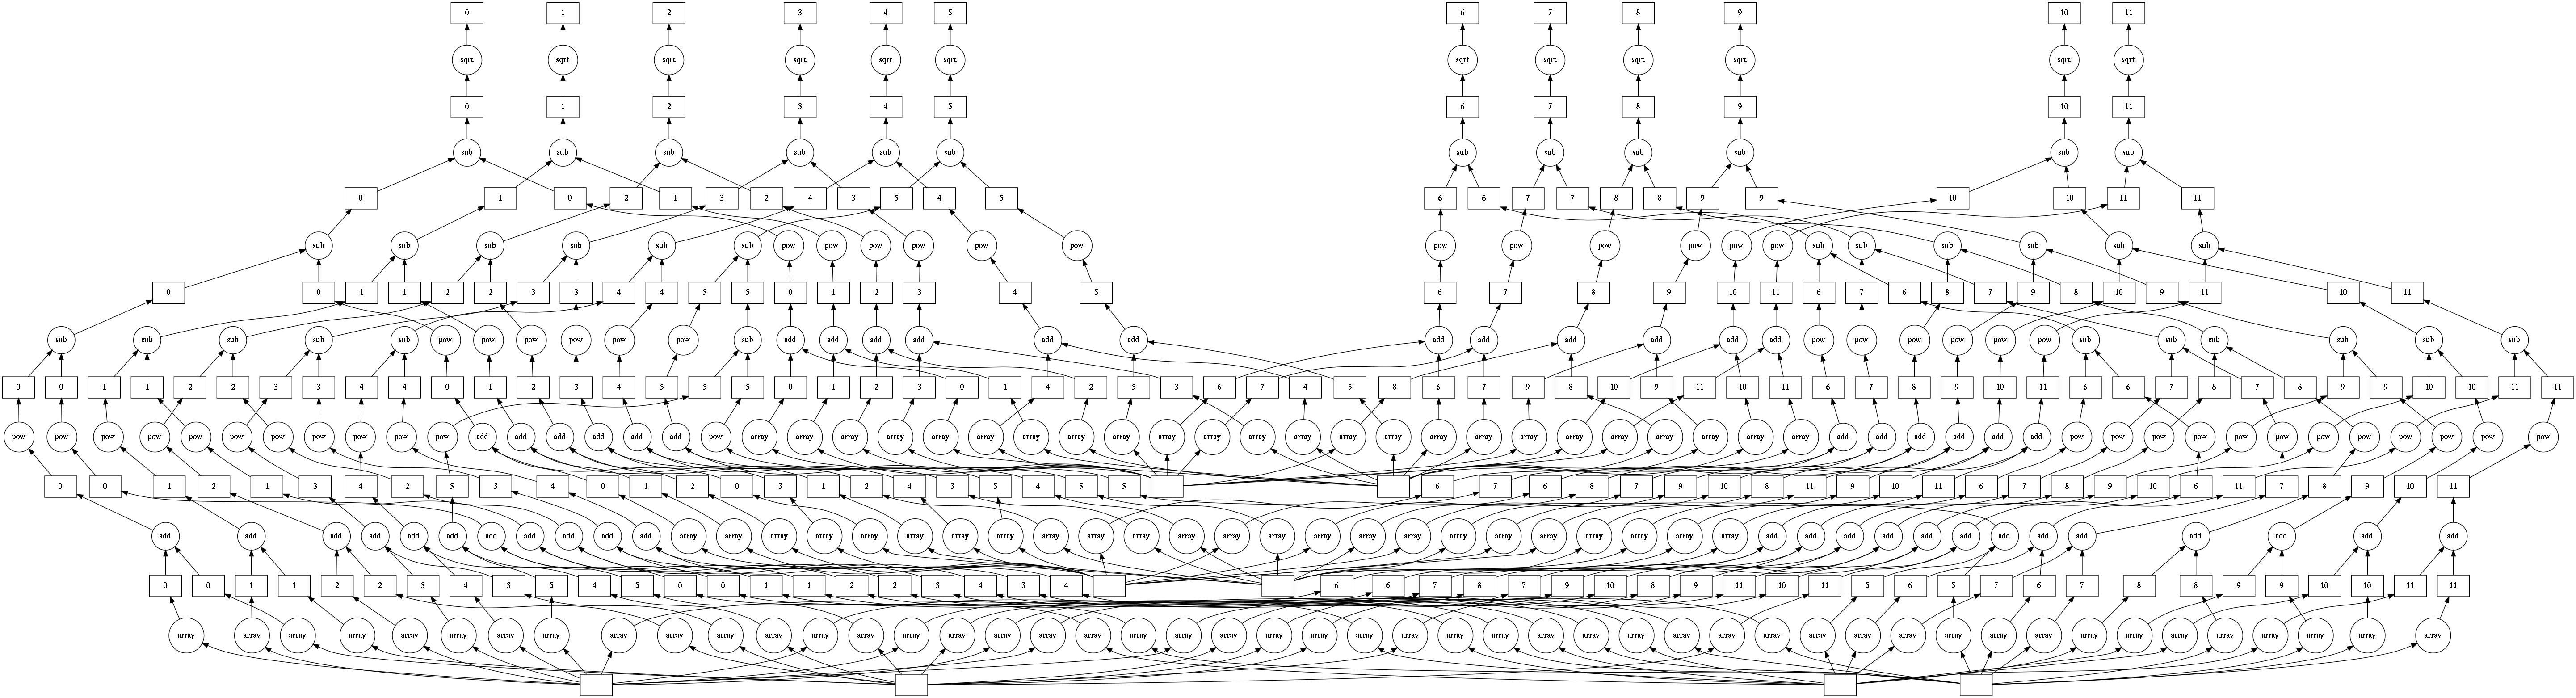

In [19]:
masses.visualize()

In [20]:
%%timeit

masses.compute()

395 ms ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br><br><br>

<center><img src="img/cython-logo.png" width="25%"></center>

<br><br><br>

In [21]:
%load_ext Cython

# Cython is a language that mixes C++ and Python. Can it help?

In [22]:
%%cython --cplus -c-O3 -a
import cython, numpy
cimport numpy
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
def cython_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2):
    out = numpy.empty(len(E1))
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] out_raw = out
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] E1_raw = E1
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] E2_raw = E2
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] px1_raw = px1
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] px2_raw = px2
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] py1_raw = py1
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] py2_raw = py2
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] pz1_raw = pz1
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] pz2_raw = pz2
    cdef int length = len(E1)
    for i in range(length):
        out_raw[i] = sqrt((E1_raw[i] + E2_raw[i])**2 - (px1_raw[i] + px2_raw[i])**2 -
                          (py1_raw[i] + py2_raw[i])**2 - (pz1_raw[i] + pz2_raw[i])**2)
    return out

In [23]:
%%timeit

masses = cython_calculate(E1, E2, px1, px2, py1, py2, pz1, pz2)

137 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<br><br><br>

<center><img src="img/pybind11-logo.png" width="40%"></center>

<br><br><br>

In [24]:
%%writefile cpp_calculate.cpp
#include <cmath>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
namespace py = pybind11;
double sqr(double x) { return x*x; }
void calculate(py::array_t<double> E1, py::array_t<double> E2,
               py::array_t<double> px1, py::array_t<double> px2,
               py::array_t<double> py1, py::array_t<double> py2,
               py::array_t<double> pz1, py::array_t<double> pz2,
               py::array_t<double> out) {
    py::buffer_info E1_info = E1.request();
    size_t length = E1_info.size;
    auto E1_raw = static_cast<double*>(E1.request().ptr);
    auto E2_raw = static_cast<double*>(E2.request().ptr);
    auto px1_raw = static_cast<double*>(px1.request().ptr);
    auto px2_raw = static_cast<double*>(px2.request().ptr);
    auto py1_raw = static_cast<double*>(py1.request().ptr);
    auto py2_raw = static_cast<double*>(py2.request().ptr);
    auto pz1_raw = static_cast<double*>(pz1.request().ptr);
    auto pz2_raw = static_cast<double*>(pz2.request().ptr);
    auto out_raw = static_cast<double*>(out.request().ptr);
    for (size_t i = 0;  i < length;  i++) {
        out_raw[i] = sqrt(sqr(E1_raw[i] + E2_raw[i]) - sqr(px1_raw[i] + px2_raw[i]) -
                          sqr(py1_raw[i] + py2_raw[i]) - sqr(pz1_raw[i] + pz2_raw[i]));
    }
}
PYBIND11_MODULE(cpp_calculate, m) {
    m.def("calculate", &calculate, "");
}

Overwriting cpp_calculate.cpp


In [25]:
%%bash

# Compile it as a Python extension module

c++ -Wall -shared -std=c++11 -fPIC -O3 -ffast-math \
    `python -m pybind11 --includes` cpp_calculate.cpp \
    -o cpp_calculate`python3-config --extension-suffix`

In [26]:
import cpp_calculate

masses = numpy.empty(len(E1), dtype=numpy.float64)
cpp_calculate.calculate(E1, E2, px1, px2, py1, py2, pz1, pz2, masses)
masses

array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [27]:
%%timeit

cpp_calculate.calculate(E1, E2, px1, px2, py1, py2, pz1, pz2, masses)

208 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br><br><br>

<center><img src="img/root-logo.png" width="40%"></center>

<br><br><br>

In [28]:
import ROOT

# With ROOT, it's much easier to mingle C++ in Python

ROOT.gInterpreter.Declare("""
double sqr(double x) { return x*x; }

void root_calculate(int length, double* E1, double* E2, double* px1, double* px2,
                    double* py1, double* py2, double* pz1, double* pz2, double* out) {
    for (int i = 0;  i < length;  i++) {
        out[i] = sqrt(sqr(E1[i] + E2[i]) - sqr(px1[i] + px2[i]) -
                      sqr(py1[i] + py2[i]) - sqr(pz1[i] + pz2[i]));
    }
}
""")

# Numpy arrays are automatically converted into C++ arrays
masses = numpy.empty(len(E1), dtype=numpy.float64)
ROOT.root_calculate(len(E1), E1, E2, px1, px2, py1, py2, pz1, pz2, masses)
masses

Welcome to JupyROOT 6.17/01


array([82.46269156, 82.46269156, 82.46269156, ..., 96.65672765,
       96.65672765, 96.65672765])

In [29]:
%%timeit

# ROOT.gInterpreter compiles declarations at minimal optimization level (-O0) because it's a commandline.

ROOT.root_calculate(len(E1), E1, E2, px1, px2, py1, py2, pz1, pz2, masses)

317 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Summary

| Method         | Capabilities                  | Time (ms) | Parallel? | Speedup |
|:---------------|:------------------------------|----------:|:---------:|--------:|
| Pure Python    | dynamic for/if                | 20600     | no        |      1× |
| Numpy          | array-at-a-time               | 426       | no        |     48× |
| NumExpr        | single-pass ufunc             |  71.3     | yes       |    289× |
| Numba          | numerical for/if              | 120       | no        |    171× |
| Numba + tricks | numerical for/if              |  80.8     | yes       |    255× |
| Numba + CUDA   | numerical for/if              |  10.7     | (GPU)     |   1925× |
| CuPy           | array-at-a-time               | 135       | (GPU)     |    153× |
| Dask           | array-at-a-time as tasks      | 376       | yes       |     55× |
| Cython         | numerical for/if (hybrid C++) | 135       | no        |    152× |
| pybind11       | numerical for/if (pure C++)   | 195       | no        |    106× |
| ROOT (`-O0`)   | numerical for/if (pure C++)   | 283       | no        |     73× |